# Assignment 5

**Submission deadline:**
* **Normal problems: Thursday, 28.05.2020**
* **Bonus problems: Deadline of Assignment 6**

**Points: 10 + 7+ bonus points**


The assignment is in the form of a Jupyter notebook. We will be using [Google Colab](https://colab.research.google.com) to solve it. Below you will find a "Setup" section. Follow instructions from this paragraph to download the notebook and open it using [Google Colab](https://colab.research.google.com). 

Your goal is to solve problems posted below. Add your solutions to the notebook.

Please do not hesitate to use GitHub’s pull requests to send us corrections!

In [ ]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.

# Download word vectors
!pip install -q gdown httpimport
![ -e word2vec.tar.xz ] || gdown 'https://drive.google.com/uc?id=1v6D8IjYVFlonhQuN_J3PML5KSVQSpbED' -O word2vec.tar.xz
![ -d word2vec ] || tar Jxf word2vec.tar.xz

# Download conversation corpuses
![ -e  hackernews_pairs.txt ] || gdown 'https://drive.google.com/uc?id=10cp2maNp1suzc5BaFQwDJr2GTKXHQOz_' -O hackernews_pairs.txt
![ -e  reddit_pairs.txt ] || gdown 'https://drive.google.com/uc?id=1Uf0Xl9aqQVBBpOwhYTV7iWCwj95FDqtL' -O reddit_pairs.txt

In [ ]:
# Huggingface Transformers implementation
!pip install -q tqdm boto3 requests regex sentencepiece sacremoses
!pip install -q transformers

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import collections

import codecs

import numpy as np
from scipy.linalg import orthogonal_procrustes
from scipy.spatial import distance

import nltk
import sklearn
nltk.download('punkt')

import pprint
import gensim

import io
from tqdm.autonotebook import tqdm


import torch


import tabulate

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Problem 1: Word Embeddings [4p]

Many natural language processing tasks requrie continuous representations for words.
[Word embeddings](https://en.wikipedia.org/wiki/Word_embedding) are mappings from a discrete
space to real-valued vectors. Word embeddings might be trained with neural networks,
either as a by-product of other tasks (e.g., language modeling, neural machine translation),
or with networks designed specifically for the word embedding task.

Two problems associated with training neural word embeddings are related to the speed of training:
(a) large volume of data, on which the network has to be trained on, and (b) time required to compute
output probability distribution over large vocabularities.

One of the most popular architectures for training word embeddings is called Word2vec [[1]()], [[2]()]. It builds on the idea that semantics of a word can be defined through the contexts,
in which the word appears in the sentence.

Let $w_1, w_2,\ldots,w_N$ be an $N$-word sentence in a natural language.
We define a context of a word $w_l$ a list of $n$ preceeding and following words
$w_{l-n},\ldots,w_{l-1},w_{l+1},\dots,w_{l+n}$.

The underlying assumption is that similar words appear in similar contexts.
For instance, words *Poland* and *Monaco* are similar in a sense, that they are singular nouns
describing abstract concepts of existing, european countries.
We can convince ourselves by looking at exceprts from Wikipedia articles
on Poland and Monaco:

* Despite **Monaco's independence** and separate foreign policy
* aimed to preserve **Poland's independence** and the szlachta's

* **Monaco joined the** Council of Europe in 2004
* **Poland joined the** Schengen Area in 2007

* nearly one-fifth **of Poland's population** – half of them
* Christians comprise a total of 83.2% **of Monaco's population**.

### Task
You will use word vectors pre-computed on a large dataset.
* **[1p]** It has been observed, that word embeddings allow to perform semantic arithmetic where, for instance

    **king** - **man** + **woman** ~= **queen**

    This *analogy* task is often used as a quality measure of word embeddings. Load word embeddings and compute
    their analogy score on a dataset of analogous pairs, expressed as an accuracy of accuracy of predicting a pair
    item (**queen** in the example above). Specifically, compare `FastText` and `Word2vec` word embeddings.
    
* **[1p]** Word embedding capture approximate semantics. Under an assumption that words of similar semantics
    exist in different languages, a mapping $W: \mathbb{R}^{300}\mapsto\mathbb{R}^{300}$ might be constructed that
    translates word embeddings between languages. It has been shown that such ortonormal mappings allow to express
    approximate, bilingual dictionaries. In addition, non-linear mappings do not offer additional benefits.

    Given a simple English-Polish dictionary of word pairs (sourced from Wikitionary)
    find an orthonormal mapping $W$ between English and Polish `FastText`
    word embeddings using Procrustes analysis.

* **[1p]** Word embeddings can often be nicely visualized.
    Make a 2-D `PCA` plot of word embeddings for countries and their capital cities
    for `FastText` or `Word2vec`. Connect each country with its capital city with a line segment.
    Can you see any regularities?
    
* **[1p]** Plot 400 roughly most frequent words' embeddings (either `FastText` or `Word2vec`) in 2-D with `PCA`.
    Skip stop words, punctuations, artifact words, etc. You can be imprecise and use heuristics
    (e.g., select words than are at lest 3 charactes long).
    Can you see any regularities? Another method of making meaningful visualizations is `t-SNE`.
    
    Make another 2-D visualization, this time using `t-SNE`. Visualizations with `t-SNE` are obtained
    with gradient descent. Try to tweak optimization parameters to get lower optimization error,
    than the one with default parameters.
    Can you see any regularities this time?

## Subtask 1: Analogies

In [ ]:
# Word embeddings assign a vector to each word. To use them we need three things:
# 1. the embeddings themselves
# 2. a dictionary from words to their embedding ids
# 3. an inverse dictionary

Embedding = collections.namedtuple(
    'Embedding',
    ['vec', 'word2idx', 'idx2word'])

In [ ]:
def load_vecs_npy(base_path):
    """Load small embeddings in .npy format."""
    vec = np.load(base_path + '.npy')
    idx2word = [l.strip() for l in codecs.open(
                      base_path + '.txt', 'r', 'utf-8')]
    word2idx = {w:i for (i,w) in enumerate(idx2word)}
    return Embedding(vec, word2idx, idx2word)

In [ ]:
# Load top 200k word embeddings: Word2vec and FastText
word2vec = load_vecs_npy('word2vec/word2vec_GoogleNews_200k')
ftext = load_vecs_npy('word2vec/fasttext_wikien_200k')

In [ ]:
def load_analogies():
    '''Load tuples of analogies, e.g., (man, woman, king, queen)'''
    questions_path = 'word2vec/questions-words.txt'
    analogies = [l.strip().split() for l in open(questions_path, 'r') \
                 if not l.startswith(':')]
    return analogies

In [ ]:
def eval_analogies(vecs, analogies):
    """
    Compute the accuracy on the analogy task.
    
    In the task, quadruples of words are given (q1, q2, r1, r2).
    The words q1 and q2 are bound by a relation. The words r1 and r2 
    are bound by the same relation. The task is to predict r2 knowing words
    q1, q2, and r1.
    
    Example:
    Quadruple [King, Queen, Man, Woman] yields the question
    King is to Queen as Man is to ????
    
    Args:
        word_vecs: Embeddings tupes
        analogies: list of quadruples: (q1, q2, r1, r2)
        
    Returns:
        percentage of correct answers
    """
    indexes = [[vecs.word2idx.get(w, None) for w in tupl] \
                for tupl in analogies]
    indexes = [tupl for tupl in indexes \
               if all([v is not None for v in tupl])]
    # indexes holds quadruples of ints giving the ids of words from our vocab.
    indexes = np.asarray(indexes)
    print('Got vocab for %d/%d pairs' % (indexes.shape[0], len(analogies)))
    
    # Extract the vectors for the query words
    q1 = vecs.vec[indexes[:, 0]]
    q2 = vecs.vec[indexes[:, 1]]
    r1 = vecs.vec[indexes[:, 2]]
    
    # Extractr the word IDs for the correct answers
    r2_inds = indexes[:, 3]

    #
    # TODO 
    #
    # Compute the approximate location of word r2 as r2 = r1 + (q2 - q1)
    # Find the word closest to this location using cosine distance.
    # Return it's id and compute the accurracy.
    #

    r2_pred = r1 + (q2-q1)

    # Normalize length and compute dot product between r2_pred and word_vecs
    # to get cosine distance
    r2_pred_norm = r2_pred / np.linalg.norm(r2_pred,axis=1).reshape(-1,1)
    vecs_norm = vecs.vec / np.linalg.norm(vecs.vec,axis=1).reshape(-1,1)
    
    # Compute in chunks to save memory
    r2_pred_inds = np.concatenate([np.argmax(r2_pred_norm[i:i+1000].dot(vecs_norm.T), axis=1) \
                                   for i in range(0, r2_pred.shape[0], 1000)])
    return 100.0 * (r2_pred_inds == r2_inds).sum() / r2_inds.shape[0]

In [ ]:
# Load analogy tuples, e.g., (man, woman, king, queen)
analogies = load_analogies()

# Some are uppercased geographical names (and FastTexts are lowercased)
analogies_lower = [[w.lower() for w in tupl] for tupl in analogies]

print(analogies[0])
print(analogies_lower[0])

['Athens', 'Greece', 'Baghdad', 'Iraq']
['athens', 'greece', 'baghdad', 'iraq']


In [ ]:
# Keep in mind that the vocab is restricted to 200k most freq words
# (in the training corpus!)
print('FastText analogy task accuracy:')
print('-------------------------------')
# Fast-text was trained on lowercased text only
print(eval_analogies(ftext, analogies_lower), '% correct')

print('\nWord2vec analogy task accuracy:')
print('-------------------------------')
# Word2vec has case information
print(eval_analogies(word2vec, analogies), '% correct')

FastText analogy task accuracy:
-------------------------------
Got vocab for 19420/19544 pairs
16.374871266735326 % correct

Word2vec analogy task accuracy:
-------------------------------
Got vocab for 18783/19544 pairs
20.859287653729435 % correct


## Subtask 2: translation through alignment of vector spaces

In [ ]:
# We're need Polish embeddings
ftext_pl = load_vecs_npy('word2vec/fasttext_wikipl_200k')

# Load a simple wikitionary-based dict of word pairs
en_pl = [l.strip().split('\t') for l in codecs.open(
    'word2vec/word2vec_en_pl', 'r', 'utf-8') if not '<UNK>' in l]
en_pl = {t[0]:t[1] for t in en_pl if len(t) == 2}

# Keep those, for which we have embeddings
en_pl = {en:pl for (en,pl) in en_pl.items() \
         if en in ftext.word2idx and pl in ftext_pl.word2idx}
print('Dictionary size:', len(en_pl))
print('good --', en_pl['good'])

Dictionary size: 750
good -- dobro


In [ ]:
# Select word embeddings for dictionary words
en_words = sorted(en_pl.keys())
V_en = ftext.vec[[ftext.word2idx[w] for w in en_words]]
V_pl = ftext_pl.vec[[ftext_pl.word2idx[en_pl[w]] for w in en_words]]
print(V_en.shape, V_pl.shape)

(750, 300) (750, 300)


In [ ]:
# Find an orthogonal transformation from V_en to V_pl.
# which minimizes square reconstruction error
W = orthogonal_procrustes(V_en, V_pl)[0]

In [ ]:
def translate(W, v, vecs2):
    #
    # TODO
    #
    # Transform source word vector v using W getting a location in target space.
    # Find the closest word in target space using the cosine distance.
    #

    v2 = W.T @ v

    vecs2_norm = vecs2.vec / np.linalg.norm(vecs2.vec,axis=1).reshape(-1,1)
    v2_norm = v2 / np.linalg.norm(v2).reshape(-1,1)

    idx = np.argmax(v2_norm.dot(vecs2_norm.T), axis=1)[0]
    return vecs2.idx2word[idx]

# Select random, fairly frequent words not from the dictionary
tr_words = [i for i in np.random.randint(1000, 2000, 100) \
            if ftext.idx2word[i] not in en_pl]
tr_words = tr_words[:20]

rows = [[ftext.idx2word[i], translate(W, ftext.vec[i], ftext_pl)] \
         for i in tr_words] 
print(tabulate.tabulate(rows))

----------  --------------
dedicated   dedykowany
types       rodzajów
rationale   wypowiadam
break       przeciąć
attended    uczęszczało
zone        strefa
alone       nawet
publishing  wydawnicze
mr          sublokator
footballer  piłkarz
champions   mistrzostwa
efforts     wysiłków
houses      budynek
nom         zostawiam
illinois    erroll
hosted      gospodarzem
finished    finałowy
peak        kulminacja
remove      usuwać
usa         czechosłowacja
----------  --------------


This method work even good for some words, for example: "zone -> strefa", but it get lost when we tried to translate names of countries, each of them are near each other in embedding space, so its`s impossible for this model to distinguish them, for example: "usa -> czechosłowacja".

## Subtask 3: PCA

In [ ]:
capitals = [l.strip().split('\t') for l in codecs.open('word2vec/countries_capitals', 'r', 'utf-8')]
capitals = {country:capital for (country,capital) in capitals}

# Select those present in Word2vec vocab
capitals = {k:v for (k,v) in capitals.items() \
            if k in word2vec.word2idx and v in word2vec.word2idx}

# Flatten the array to have a list of [country, capital, country, capital, ...]
geo = [e for pair in capitals.items() for e in pair]
print(len(geo) // 2, 'pairs', geo[:6])

131 pairs ['Afghanistan', 'Kabul', 'Albania', 'Tirana', 'Algeria', 'Algiers']


In [ ]:
geo_inds = [word2vec.word2idx[w] for w in geo]
geo_vecs = word2vec.vec[geo_inds]
print(geo_vecs.shape)

(262, 300)


In [ ]:
from sklearn.decomposition import PCA

#
# TODO
# use PCA from sklearn.decomposition to project the countries and capitals into 2D.
# draw lines connecting each country with its capital
#
# Hint:
# - the function "annotate" can be used to put text onto the plot
#

pca = PCA(n_components=2)
geo_vecs_pca = pca.fit_transform(geo_vecs)

In [ ]:
geo_vecs_pca[:2]

array([[-0.7314497 , -0.29290706],
       [ 1.0900247 ,  0.53762937]], dtype=float32)

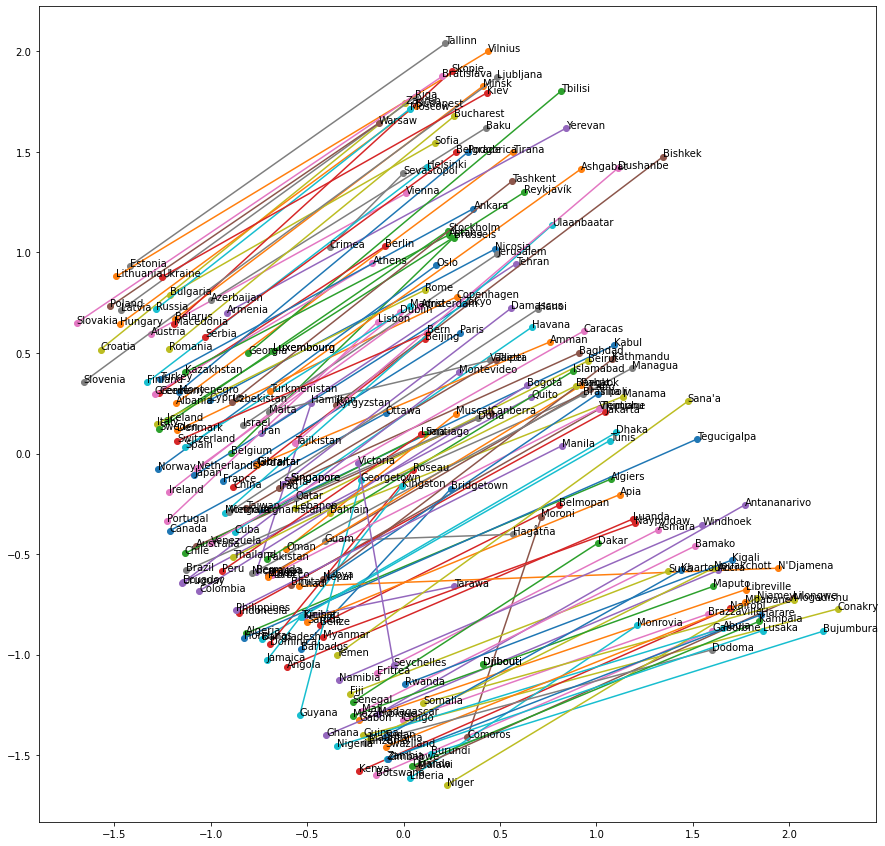

In [ ]:
plt.figure(figsize=(15,15))
for i in range(0,len(geo_vecs_pca),2):
    plt.plot(geo_vecs_pca[i:i+2][:,0],geo_vecs_pca[i:i+2][:,1],'o-')
    plt.annotate(geo[i],geo_vecs_pca[i])
    plt.annotate(geo[i+1],geo_vecs_pca[i+1])
plt.show()

As we can see, most of the lines are parallel, so difference between countries and their capitals are nearly the same.

## Subtask 4: PCA vs t-SNE on frequent words

In [ ]:
# Select words starting from the 200th to ommit stop words,
# which have at least 3 chars
top_words = [w for (i,w) in enumerate(ftext.idx2word) \
             if i > 200 and len(w) >= 3][:400]
top_inds = [ftext.word2idx[w] for w in top_words]

top_vecs = ftext.vec[top_inds]
pca = PCA(n_components=2,whiten=True)
top_vecs_pca = pca.fit_transform(top_vecs)

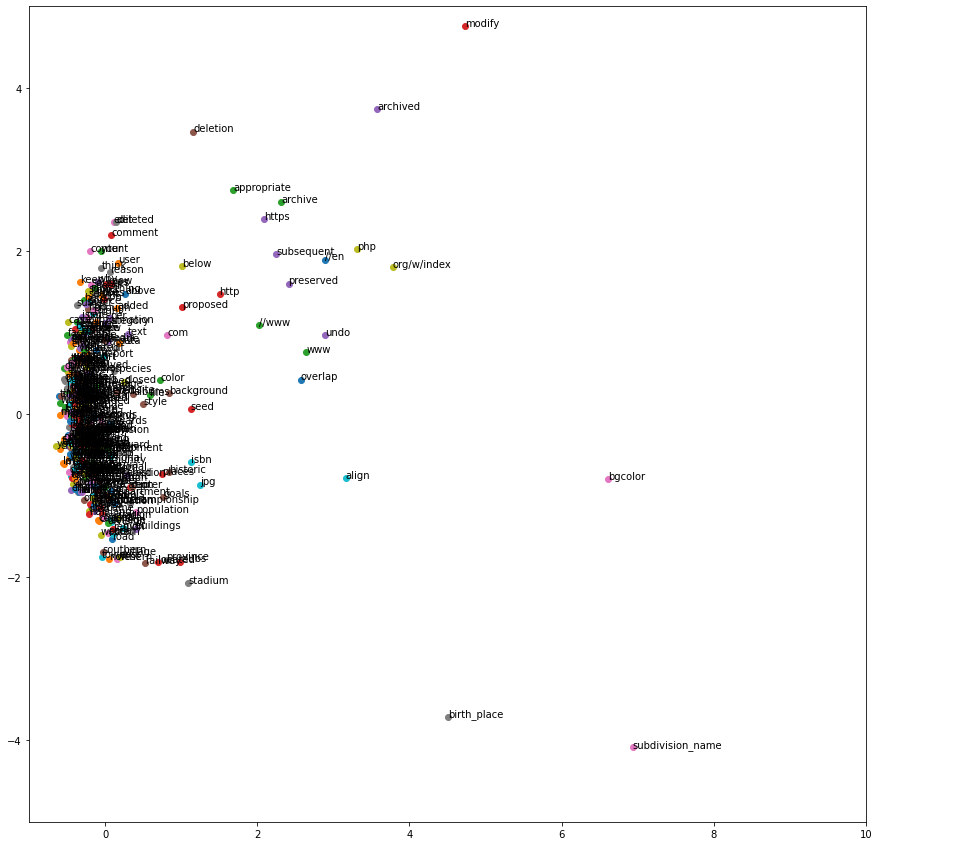

In [ ]:
#
# TODO: make a 2D PCA projection of the selected words.
#

plt.figure(figsize=(15,15))
plt.xlim(-1,10)
plt.ylim(-5,5)
for i in range(len(top_vecs_pca)):
    plt.annotate(top_words[i],top_vecs_pca[i,:])
    plt.plot(top_vecs_pca[i,:][:1],top_vecs_pca[i,:][1:],'o-')

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
top_vecs_tsne = tsne.fit_transform(top_vecs)

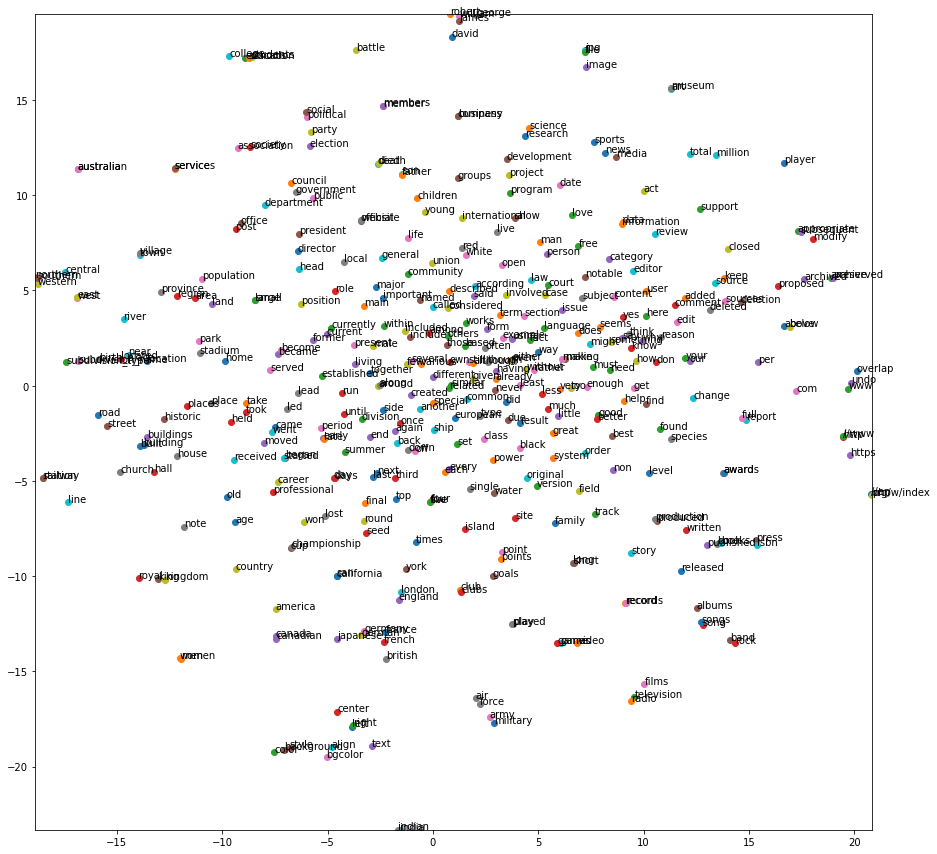

In [ ]:
#
# TODO: make a 2D t-SNE projection of the selected words.
# Things will cluster much nicer
#

plt.figure(figsize=(15,15))
plt.xlim(np.min(top_vecs_tsne,axis=0)[0],np.max(top_vecs_tsne,axis=0)[0])
plt.ylim(np.min(top_vecs_tsne,axis=0)[1],np.max(top_vecs_tsne,axis=0)[1])
for i in range(len(top_vecs_pca)):
    plt.annotate(top_words[i],top_vecs_tsne[i,:])
    plt.plot(top_vecs_tsne[i,:][:1],top_vecs_tsne[i,:][1:],'o-')

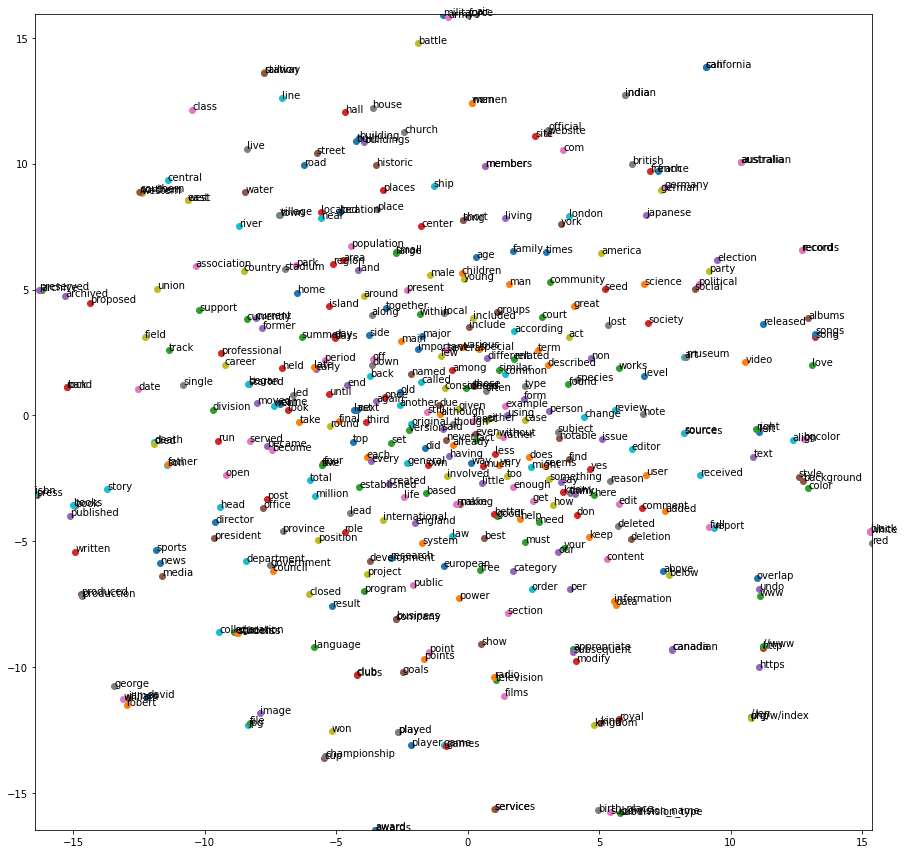

In [ ]:
tsne = TSNE(n_components=2,perplexity=40,early_exaggeration=30.0,learning_rate=50.0)
top_vecs_tsne = tsne.fit_transform(top_vecs)

plt.figure(figsize=(15,15))
plt.xlim(np.min(top_vecs_tsne,axis=0)[0],np.max(top_vecs_tsne,axis=0)[0])
plt.ylim(np.min(top_vecs_tsne,axis=0)[1],np.max(top_vecs_tsne,axis=0)[1])
for i in range(len(top_vecs_pca)):
    plt.annotate(top_words[i],top_vecs_tsne[i,:])
    plt.plot(top_vecs_tsne[i,:][:1],top_vecs_tsne[i,:][1:],'o-')

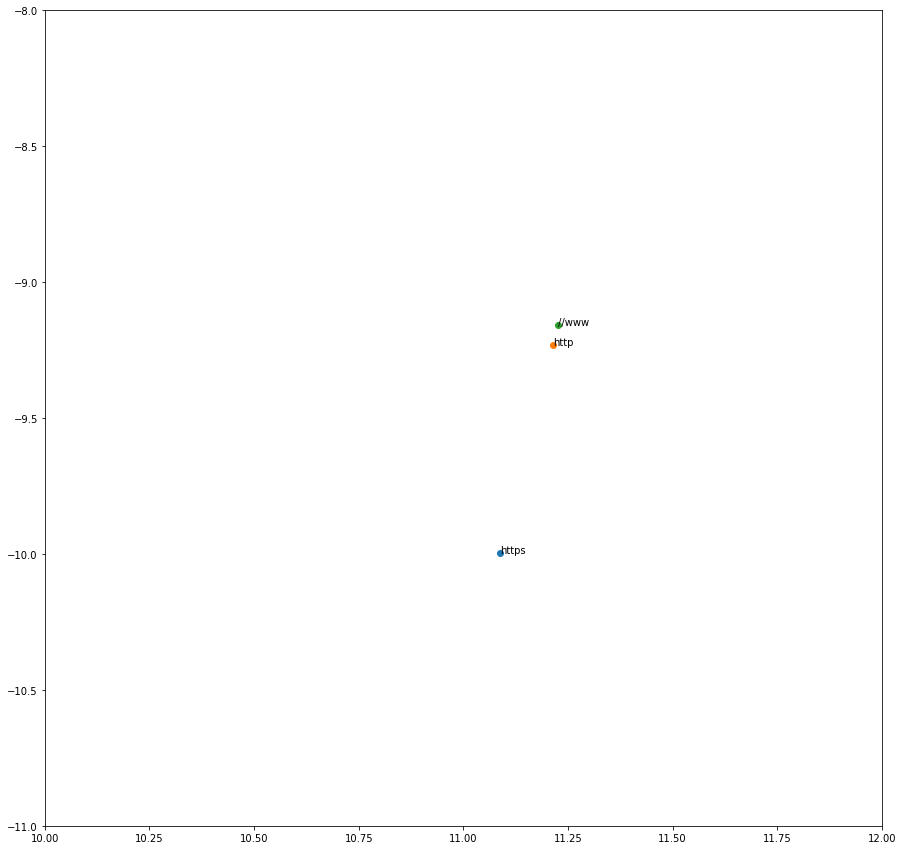

In [ ]:
# TODO: zomm in on 3 meaningful clusters

x_min,x_max = 10,12
y_min,y_max = -11,-8
plt.figure(figsize=(15,15))
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
for i in range(len(top_vecs_pca)):
    if x_min <= top_vecs_tsne[i,:][0] <= x_max and y_min <= top_vecs_tsne[i,:][1] <= y_max:
        plt.annotate(top_words[i],top_vecs_tsne[i,:])
        plt.plot(top_vecs_tsne[i,:][:1],top_vecs_tsne[i,:][1:],'o-')

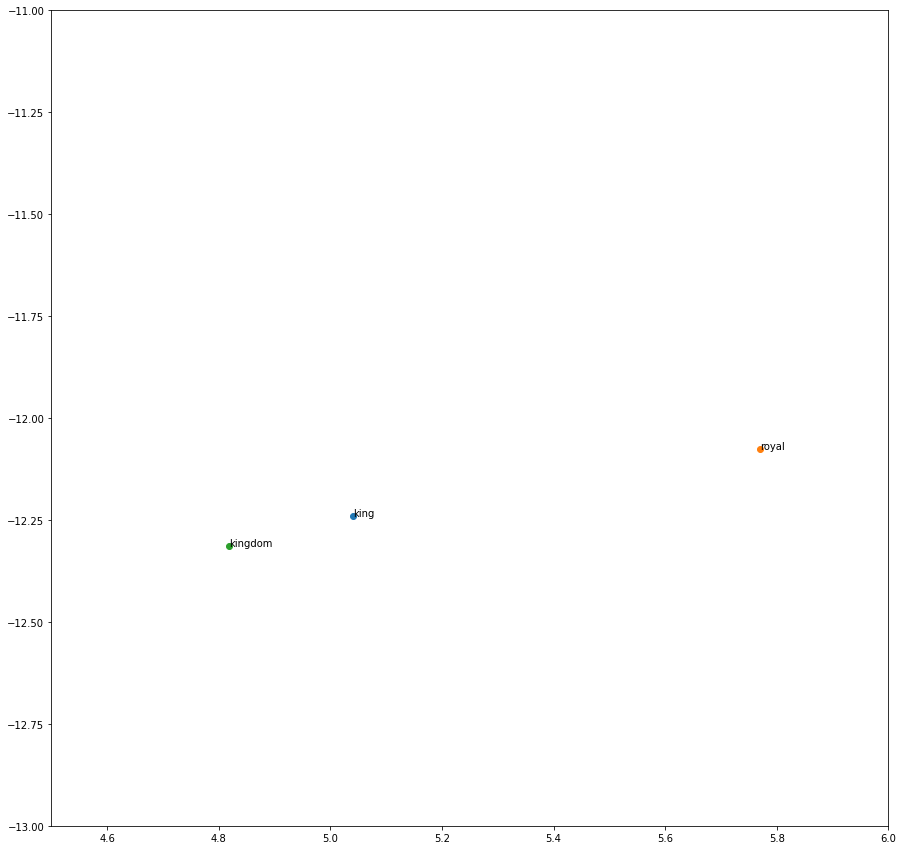

In [ ]:
x_min,x_max = 4.5,6
y_min,y_max = -13,-11
plt.figure(figsize=(15,15))
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
for i in range(len(top_vecs_pca)):
    if x_min <= top_vecs_tsne[i,:][0] <= x_max and y_min <= top_vecs_tsne[i,:][1] <= y_max:
        plt.annotate(top_words[i],top_vecs_tsne[i,:])
        plt.plot(top_vecs_tsne[i,:][:1],top_vecs_tsne[i,:][1:],'o-')

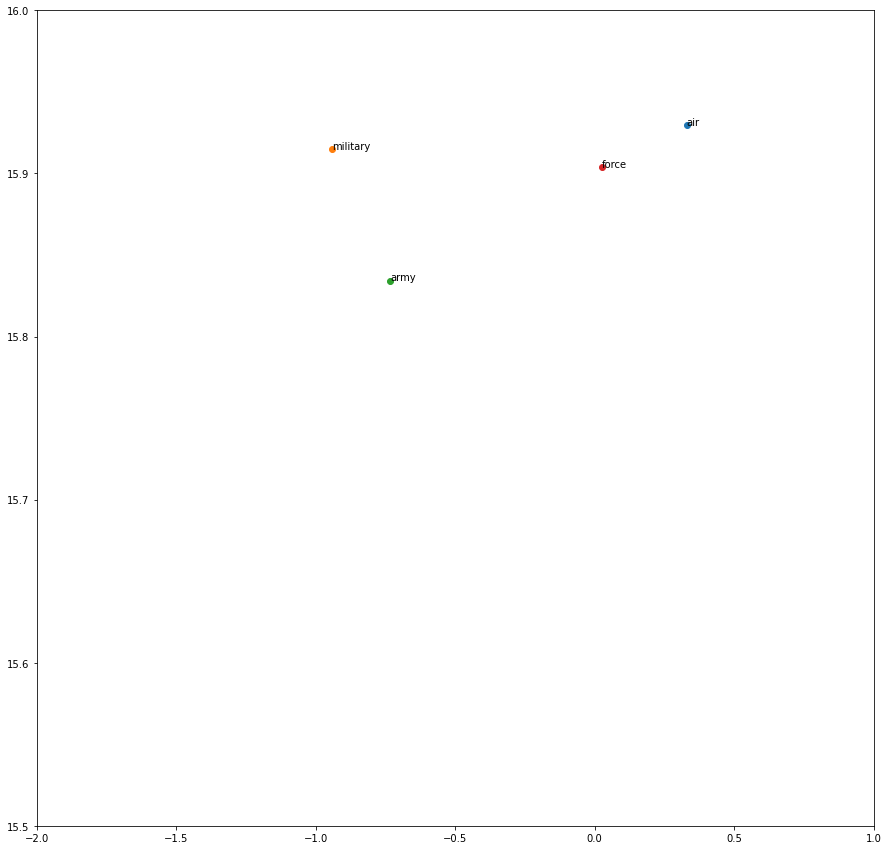

In [ ]:
x_min,x_max = -2,1
y_min,y_max = 15.5,16
plt.figure(figsize=(15,15))
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
for i in range(len(top_vecs_pca)):
    if x_min <= top_vecs_tsne[i,:][0] <= x_max and y_min <= top_vecs_tsne[i,:][1] <= y_max:
        plt.annotate(top_words[i],top_vecs_tsne[i,:])
        plt.plot(top_vecs_tsne[i,:][:1],top_vecs_tsne[i,:][1:],'o-')

PCA didn`t give us useful information, but with t-SNE we can see some clusters, like those above. 

# Problem 2: kNN Talker [6p + 7bp]

In this exercise you will build a simple chatbot that uses distributed representations of words and sentences to perform a neares neighbor selection of responses.

We have collected two sets of data:
- `./reddit_pairs.txt` of excerpts of [Reddit](https://www.reddit.com/) conversations,
- `./hackernews_pairs.txt` of excertps from [Hackernews](https://news.ycombinator.com/).

The two corpuses are formatted as `tab`-separated pairs of utterances: a `prompt` and a `response`. Successive lines belong to different conversations.

The main idea of the chatbot is to build a representation of the user `input` and of all `prompts` from the corpus. Then select the best (or randomly one of the top few) matches and print the associated `response`.

The key to get the bot working is to create good sentence representations. We will try:
- averaging word embeddings
- using sentence models such as BERT.

### Warning:
The Reddit corpus may contain abusive language, it was not heavily cleaned.

### Tasks
The code below is a starting point, but you can develop you own. The following list suggests some actions to try, along with the points that reflect our subjective hardness. The exercise is worth 6 regular points (i.e. the report, word embedding-based model and BERT-based model), anything on top of it will be counted as a bonus.

1. [MANDATORY] type in a Markdown cell a report of your actions, what did you try, why, what was the result. Show exemplary conversations (they must be probable under your model) [2p].
2. Represent sentences by averaging their word vectors. Properly handle tokenization (you can use regular expressions or e.g. `nltk` library). Describe how you handle lower and upper cased words. Try a fw nearest neighbor selection methods (such as euclidean or cosine distance). See how embedding normalization affects the results (you can normalize individual word vectors, full sentence vectors etc.) [2p]
3. Use the [transformers](https://huggingface.co/transformers) package to load a pretrained BERT model. Use it to represent sentences by e.g. averaging the activations in the last layer [2p].
4. Cherry-pick 3 nice dialogues [1p].
5. Incoportate context: keep a running average of past conversation turns [1p].
6. Do data cleaning, finding rules for good responses [1p].
7. Do profanity cleaning [1p].
8. Try mixing different sentence representation techniques [1p].
9. Try to custer responses to the highest scored prompts. Whic arsponses are more funny: form the largerst or from the smalles cluster? [2p].
10. Implement your own enhancements [?bp].


In [ ]:
prompts = []
responses = []
err_lines = []
with open('./hackernews_pairs.txt') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        line = line.split('\t')
        if len(line)!=2:
            err_lines.append(line)
        else:
            prompts.append(line[0])
            responses.append(line[1])

if err_lines:
    print(f"Failed to parse the following {len(err_lines)} lines: {err_lines}") 
print(f"Sample dialogue pairs: \n{pprint.pformat(list(zip(prompts[:15], responses)))}")

Sample dialogue pairs: 
[('Ah, yep, that was the issue.',
  'Yeah, options typically cost the company very little.'),
 ("Cross multiplication is a trick to multiply by the 'reciprocal' of the "
  'fraction.',
  'Oh, I see.'),
 ("Cross multiplication is a trick to multiply by the 'reciprocal' of the "
  'fraction.',
  'Whaaa?'),
 ('Quite cool.', 'It gets into a pretty philosophical area.'),
 ("If only the packaging smells, then I agree, it's not damaged.",
  'Sounds like entitlement to me.'),
 ("That's what nationalist politics always says.", 'Can you prove that?'),
 ('Misleading title.', 'Not really.'),
 ('Misleading title.',
  'It is not completely misleading to all users but enough for me to say '
  'something.'),
 ('Why the hell is this getting downvoted?',
  "Because it's clear the person he's responding to understood that "
  'relationship.'),
 ("There's a web without ads.",
  'This just came to mind when you mentioned "ad tax".'),
 ('God bless the designated typer in the mob.',
 

In [ ]:
class BasicEncoder:
    def encode(self, sentence):
        # this is a base class!
        raise NotImplementedError

    def encode_corpus(self, sentences):
        ret = [self.encode(sentence) for sentence in tqdm(sentences)]
        return np.vstack(ret)

The code below implements a simple baseline: we encode each sentence as a sparse vector which sums word occurrences.

In [ ]:
class OneHotEncoder(BasicEncoder):
    def __init__(self, sentences):
        self.vectorizer = sklearn.feature_extraction.text.CountVectorizer()
        self.vectorizer.fit(sentences)
    
    def encode(self, sentence):
        return self.vectorizer.transform([sentence])[0]

    def encode_corpus(self, sentences):
        # Override because sklearn already works on batches
        encodings = self.vectorizer.transform(sentences)
        # Note: this code needs to handl the scipy sparse matrix
        # which has subtle differences with numpy ndarrays
        norms = np.array((encodings.power(2)).sum(1))**0.5
        encodings = encodings.multiply(1.0 / norms)
        return encodings

encoder = OneHotEncoder(prompts)
encodings = encoder.encode_corpus(prompts)

prompt = "Ultimate question: Windows or Linux?"
enc = encoder.encode(prompt)

# Deal with encodings being sparse matrices. Word2vecs will not have the pecularities
scores = (encodings @ enc.T).toarray().ravel()
top_idx = scores.argsort()[-10:][::-1]

for idx in top_idx:
    print(scores[idx], prompts[idx], ':', responses[idx])

1.0 Question. : In a sense 'maybe not'.
1.0 Linux? : Unfortunately not.
1.0 Windows? : Unix based systems
1.0 Question. : This is a good question!
0.8017837257372732 Hardware or software or technique or best practices... : Mobile phones that still work when you drop them.
0.8017837257372732 Hardware or software or technique or best practices... : Floppy disk and cd/dvd drives!
0.8017837257372732 Hardware or software or technique or best practices... : Building your own desktop.
0.8017837257372732 Hardware or software or technique or best practices... : Extreme programming.
0.8017837257372732 Hardware or software or technique or best practices... : Zip drives.
0.8017837257372732 Hardware or software or technique or best practices... : It can all go.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


## ChatBot

In [ ]:
# TODO: build a simple dialogue system using these k-neares neighbor matches, 
# perform a few test conversations

class ChatBot:
    def __init__(self,Encoder,top_n=5,distance='cosine',encodings=None):
        self.Encoder = Encoder
        self.top_n = top_n
        self.distance = distance
        self.encodings = encodings

    def nearest(self,enc,encodings):
        if self.distance == 'cosine':
            if isinstance(encodings, numpy.ndarray):
                scores = encodings @ enc.T
            else:
                scores = (encodings @ enc.T).toarray().ravel()
            top_idx = scores.argsort()[-self.top_n:][::-1]
            return random.choice(top_idx)
        elif self.distance == 'euclidean':
            scores = -2 * np.dot(enc, encodings.T) + np.sum(encodings**2,axis=1)
            top_idx = scores.argsort()[:self.top_n]
            return random.choice(top_idx)
        else:
            return -1

    def chat(self):
        encoder = self.Encoder(prompts)
        if not isinstance(self.encodings,numpy.ndarray):
            encodings = encoder.encode_corpus(prompts)
        else:
            encodings = self.encodings
        while True:
            prompt = input('\n')
            enc = encoder.encode(prompt)
            idx = self.nearest(enc,encodings)
            print(responses[idx])


In [ ]:
cb = ChatBot(OneHotEncoder,3)
#cb.chat()

## Word embeddings

In [ ]:
class Word2VecEncoder(BasicEncoder):
    def __init__(self, sentences, vecs = word2vec,\
                 normalize_words=False,normalize_sentencces=True,normalize_res=False):
        self.sentences = sentences
        self._vecs = vecs
        self.nw = normalize_words
        self.ns = normalize_sentencces
        self.nr = normalize_res
        
    def _get_vec(self, word):
        # Find the vector for word, or use a suitbale out-of-vocabulary vector
        # For extra points try backing off to a lowercased dictionary
        idx = self._vecs.word2idx.get(word,-1)
        if idx == -1:
            return np.zeros(300)
        if self.nw:
            return self._vecs.vec[idx] / (np.linalg.norm(self._vecs.vec[idx]) + 1e-5)
        else:
            return self._vecs.vec[idx]

    def encode(self, sentence):
        ret = np.zeros(self._vecs.vec.shape[1])
        for token in nltk.tokenize.word_tokenize(sentence):
            word_vec = self._get_vec(token)
            ret += word_vec
            if self.nr:
                ret /= (np.linalg.norm(ret) + 1e-5)
        if self.ns:
            ret /= (np.linalg.norm(ret) + 1e-5)
        return ret



In [ ]:
encoder = Word2VecEncoder(prompts)
encodings = encoder.encode_corpus(prompts)

prompt = "Ultimate question: Windows or Linux?"
enc = encoder.encode(prompt)

# Cosine distance
scores = encodings @ enc.T
top_idx = scores.argsort()[-10:][::-1]

for idx in top_idx:
    print(scores[idx], prompts[idx], ':', responses[idx])

0.8153610266356541 Windows? : Unix based systems
0.791016894427061 Linux? : Unfortunately not.
0.7219338960578671 Windows 10 is not free. : That's comparing enterprised apples to open-sourced oranges.
0.7018985503780901 2016 is the year of desktop linux. : First, the website is down.
0.7018985503780901 2016 is the year of desktop linux. : It's since 2006 that every year is gonna be the year of linux on the desktop.
0.7018985503780901 2016 is the year of desktop linux. : I doubt there are enough people who care.
0.7018985503780901 2016 is the year of desktop linux. : I'm inclined to agree, albeit begrudgingly.
0.6945486833969474 Running desktop linux : Free-form speech recognition
0.6902800407164611 Windows is slow? : It's really not that fast.
0.6639382526244508 OS X server mail setup is easy. : Yes---you're absolutely right.


In [ ]:
cb = ChatBot(Word2VecEncoder,3)
#cb.chat()



Ultimate question: Windows or Linux?
Unfortunately not.

Ultimate question: Windows or Linux?
That's comparing enterprised apples to open-sourced oranges.

What's your name?
What utter nonsense.

But why are you so rude?
People can create fake accounts with other person email.

Ok, I see your point
Do people really travel outside of their comfort zone?

Yes, but only if they really want this
It is not an embarrassment.

Exactly
I think this ignores the process required to get something "proven to work".


KeyboardInterrupt: ignored

In [ ]:
#Euclidean distance

scores2 = -2 * np.dot(enc, encodings.T) + np.sum(encodings**2,axis=1)
top_idx2 = scores2.argsort()[:10]

for idx in top_idx2:
    print(scores2[idx], prompts[idx], ':', responses[idx])

-0.6307275315463564 Windows? : Unix based systems
-0.5820393901109089 Linux? : Unfortunately not.
-0.44387126575256 Windows 10 is not free. : That's comparing enterprised apples to open-sourced oranges.
-0.40379976732720724 2016 is the year of desktop linux. : I'm inclined to agree, albeit begrudgingly.
-0.40379976732720724 2016 is the year of desktop linux. : I doubt there are enough people who care.
-0.40379976732720724 2016 is the year of desktop linux. : First, the website is down.
-0.40379976732720724 2016 is the year of desktop linux. : It's since 2006 that every year is gonna be the year of linux on the desktop.
-0.3891000913281004 Running desktop linux : Free-form speech recognition
-0.3805639257453042 Windows is slow? : It's really not that fast.
-0.32787847791083546 OS X server mail setup is easy. : Yes---you're absolutely right.


In [ ]:
cb = ChatBot(Word2VecEncoder,3,distance='euclidean')
#cb.chat()



Hello
My take for what it's worth.

Neural networks are great!
This is practical, however I strongly disagree with this semantically.

Oh, so maybe I was wrong
When did generation y get absorbed by the word millennials?

Idk
How so?

I didn't read whole Wikipedia as you
Less employees is how I interpret it.

Ultimate question: Windows or Linux?
That's comparing enterprised apples to open-sourced oranges.

But apples or oranges?
".. constant improvements and upgrades .." == marketing vomit.

Windows updates are the worst
That's comparing enterprised apples to open-sourced oranges.


KeyboardInterrupt: ignored

### Different normalizations

In [ ]:
# Normalize both words vector and sentence vector
encoder = Word2VecEncoder(prompts,normalize_words=True)
encodings = encoder.encode_corpus(prompts)

prompt = "Ultimate question: Windows or Linux?"
enc = encoder.encode(prompt)

# Cosine distance
scores = encodings @ enc.T
top_idx = scores.argsort()[-10:][::-1]

for idx in top_idx:
    print(scores[idx], prompts[idx], ':', responses[idx])


0.731819484267586 Windows? : Unix based systems
0.699710596633156 Linux? : Unfortunately not.
0.6417526045818337 OS X server mail setup is easy. : Yes---you're absolutely right.
0.6347479087362393 Running desktop linux : Free-form speech recognition
0.6226666734242404 Are you taking about a mobile app or a desktop one ? : Thanks for the recommendations!
0.6205033863232445 Windows 10 is not free. : That's comparing enterprised apples to open-sourced oranges.
0.6069248717316786 How is downloading cracked software or stolen movies an ethical issue? : Primarily, it's a legal issue.
0.5948869575142607 Do you test the functionality of your git client or code editor? : On first use, i guess i have checked these parts one way or another.
0.5935781882379623 i wouldn't even call a machine without ecc a server or workstation. : This  was  many, maybe more than 10, years ago.
0.5929193680117858 2016 is the year of desktop linux. : It's since 2006 that every year is gonna be the year of linux on t

In [ ]:
# Normalize only words vectors
encoder = Word2VecEncoder(prompts,normalize_words=True,normalize_sentencces=False)
encodings = encoder.encode_corpus(prompts)

prompt = "Ultimate question: Windows or Linux?"
enc = encoder.encode(prompt)

# Cosine distance
scores = encodings @ enc.T
top_idx = scores.argsort()[-10:][::-1]

for idx in top_idx:
    print(scores[idx], prompts[idx], ':', responses[idx])


13.252878969664307 Well you want all that user data so you can mine if for advertisers don't you? : Right, especially for "advertisers" with three letter acronyms.
12.536215450241528 I wonder how bad is that for your teeth if you don't have to chew on your food. : Not very.
12.519834100975459 I can't tell if you're incredibly naive or if you just believe your parents are. : There's such a thing as not rubbing their noses in it....
12.468263172125713 Do you just plug it in when you hop in the car or did you wire it yourself? : benmanns basicaly has my setup down.
12.468263172125713 Do you just plug it in when you hop in the car or did you wire it yourself? : Usually dash cams come with a 12v/cigarette lighter charging cord.
12.235579337512766 I don't think you can do all 3 well at the same time, nor should you try. : Thought so too.
12.11278528376722 I just can't decide if there will be more blood, or if this is just the start... : In 2008 I watched the market drop 5% every day for a w

In [ ]:
# Normalize word vector and sentence vector for each addition
encoder = Word2VecEncoder(prompts,normalize_words=True,normalize_res=True)
encodings = encoder.encode_corpus(prompts)

prompt = "Ultimate question: Windows or Linux?"
enc = encoder.encode(prompt)

# Cosine distance
scores = encodings @ enc.T
top_idx = scores.argsort()[-10:][::-1]

for idx in top_idx:
    print(scores[idx], prompts[idx], ':', responses[idx])


0.8383115457745653 Linux? : Unfortunately not.
0.7632419334318963 Windows? : Unix based systems
0.7464844774148769 2016 is the year of desktop linux. : I doubt there are enough people who care.
0.7464844774148769 2016 is the year of desktop linux. : I'm inclined to agree, albeit begrudgingly.
0.7464844774148769 2016 is the year of desktop linux. : First, the website is down.
0.7464844774148769 2016 is the year of desktop linux. : It's since 2006 that every year is gonna be the year of linux on the desktop.
0.725580501107563 Running desktop linux : Free-form speech recognition
0.6776134488685409 So... what then do you prefer for your desktop? : Depends on the task, and I'm not exactly a typical case.
0.6641778722644855 If anything it shows how silly it is to call the operative system for "linux". : For better or worse, operating systems are typically named for their kernel.
0.6492935399253196 i wouldn't even call a machine without ecc a server or workstation. : This  was  many, maybe m

In [ ]:
# Normalize only sentence vector for each addition
encoder = Word2VecEncoder(prompts,normalize_words=False,normalize_res=True)
encodings = encoder.encode_corpus(prompts)

prompt = "Ultimate question: Windows or Linux?"
enc = encoder.encode(prompt)

# Cosine distance
scores = encodings @ enc.T
top_idx = scores.argsort()[-10:][::-1]

for idx in top_idx:
    print(scores[idx], prompts[idx], ':', responses[idx])


0.9735476571649431 Linux? : Unfortunately not.
0.7793940483902535 Running desktop linux : Free-form speech recognition
0.7780591742906213 2016 is the year of desktop linux. : I doubt there are enough people who care.
0.7780591742906213 2016 is the year of desktop linux. : I'm inclined to agree, albeit begrudgingly.
0.7780591742906213 2016 is the year of desktop linux. : First, the website is down.
0.7780591742906213 2016 is the year of desktop linux. : It's since 2006 that every year is gonna be the year of linux on the desktop.
0.7489705381347247 Windows? : Unix based systems
0.7420199693121676 If anything it shows how silly it is to call the operative system for "linux". : For better or worse, operating systems are typically named for their kernel.
0.7323718707012616 i think they use linux : They also get apples occasionally.
0.7317603811418429 I want to replace my macbook air 11 by something light, quiet and running linux. : It'd be hard for us to make this decision for you.


## BERT

In [ ]:
from transformers import BertTokenizer, BertModel

In [ ]:
class BERTEmbedding(BasicEncoder):
    def __init__(self, sentences):
        self.sentences = sentences
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
        self.model = BertModel.from_pretrained('bert-base-cased')
        self.model.eval()
        self.model.to('cuda')

    def encode(self, sentence):
        sentance = "[CLS] " + sentence + " [SEP]"
        tokenized_sentance = self.tokenizer.tokenize(sentance)
        indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_sentance)
        tokens_tensor = torch.tensor([indexed_tokens])
        tokens_tensor = tokens_tensor.to('cuda')
        with torch.no_grad():
            outputs = self.model(tokens_tensor)

        ret = np.array(outputs[0][0].sum(0).to('cpu'))
        ret /= (np.linalg.norm(ret) + 1e-5)
        return ret


In [ ]:
encoder = BERTEmbedding(prompts)
encodings = encoder.encode_corpus(prompts)

In [ ]:
prompt = "Ultimate question: Windows or Linux?"
enc = encoder.encode(prompt)

# Cosine distance
scores = encodings @ enc.T
top_idx = scores.argsort()[-10:][::-1]

for idx in top_idx:
    print(scores[idx], prompts[idx], ':', responses[idx])

0.87846845 The challenging question is: do you have kids? : One kid, lives with my ex-wife.
0.8740117 The short answer is: launch costs and crap rockets. : Now factor in all the failures on the pad.
0.8709185 Side question: is there any similar cloud service with hard billing caps? : I'd really love to know.
0.8696867 To work with other operating systems? : Then why not have it optional?
0.86720645 what solution did you end up with (soft- or hardware?) : Yes, please... what did you wind up using?
0.8666847 "other operating systems" like windows 2000? : Seriously?
0.862018 How about (automated) testing? : Indeed - I'd argue that's the most important one.
0.862018 How about (automated) testing? : That one is important.
0.862018 How about (automated) testing? : It's necessary, but insufficient.
0.8611037 The real question is when they will release a socketed version. : I'd love to see these parts on the desks of developers.


In [ ]:
cb = ChatBot(BERTEmbedding,3,encodings=encodings)
cb.chat()


Hello
What's up ?

Are neural networks great?
Twilio for sms messages, working well.

What is Twilio?
It happens when a provider advertises their internal routes to the world.

"Ultimate question: Windows or Linux?"
The two terms are synonymous at this point.

Ultimate question: Windows or Linux?
One kid, lives with my ex-wife.

Want to talk about politics?
Where, specifically?

Here, specifically.
How exactly would we be technologically poorer in this case?

I take it as a yes
Flattery will get you everywhere :}

So you are great bot!
Bots are people too!

Don't get me wrong, but you're not human.
Of course it is.

I'm sorry, but not
So what hypotheses so far don't have a counter-example?

So you wanna talk about Millennium Prize Problems?
Indeed.

Do you think you can solve one of them?
but it's also ok to formulate testable hypotheses in here.

if it helps you, why not
Well, it depends on what I'm doing.

Millennium Prize Problems
These seem to be terribly vague, e.g.

Ok, bye


## Report

The first step was to create a simple chatBot class witch chat method, which is a simple infinite loop with input on each iteration. With given input, I can select the nearest prompt and print answer.

Now, using OneHotEncoder I could make first chats.
(Bot is randomly selecting one of the top 5 answers)
```
Hello
Hey

What`s your name?
I think his point is that we  still  have bad actors and states.

What are you talking about?
all those brands have official brand imports.

Ok, bye
I liked your reply so much I had to do more than just upvote.
```

```
Ultimate question: Windows or Linux?
This is a good question!

This is a good answer!
This is heartening.
```
This solution is really simple, so the results aren't stunning, but we can get some good answers.

The second step was to fill the implementation of Word2VecEncoder. I decided to don't lowercased my words because in word2vec we have also some default-cased words. The first version of my encoder normalize full-sentence vectors. Looking at answers on "Ultimate question: Windows or Linux?" we can see that this method works better than OneHotEncoding. We can see this also in some chats:

(This and every next bot is randomly selecting one of the top 3 answers)
```
Ultimate question: Windows or Linux?
That's comparing enterprised apples to open-sourced oranges.

What's your name?
What utter nonsense.

But why are you so rude?
People can create fake accounts with other person email.

Ok, I see your point
Do people really travel outside of their comfort zone?

Yes, but only if they really want this
It is not an embarrassment.

Exactly
I think this ignores the process required to get something "proven to work".
```

I tried also using euclidean distance inside KNN, the answers to "Ultimate question: Windows or Linux?" are the same, I made some chats with those bots, for example:

```
Hello
My take for what it's worth.

Neural networks are great!
This is practical, however I strongly disagree with this semantically.

Oh, so maybe I was wrong
When did generation y get absorbed by the word millennials?

Idk
How so?

I didn't read whole Wikipedia as you
Less employees is how I interpret it.

Ultimate question: Windows or Linux?
That's comparing enterprised apples to open-sourced oranges.

But apples or oranges?
".. constant improvements and upgrades .." == marketing vomit.

Windows updates are the worst
That's comparing enterprised apples to open-sourced oranges.
```

I switched back to cosine distance, I think is better in this case.

The next step was to experiment with embedding normalization:
* Normalize both words vector and sentence vector - in this case, a new word has less impact on the result than before
* Normalize only words vectors - I don't think that this is a good idea, because the results vector aren't normalized
* Normalize word vector and sentence vector for each addition - for each new word I normalize this words vector, add it to the result and then normalize whole result vector, so each time two normalized vectors are adding. In this case, a new vector has a greater impact on the result than before
* Normalize only sentence vector for each addition - in this case, a new word has the biggest impact on the result

The next step required the use of BERT model. I downloaded Bert model and Bert tokenizer. For every sentence, I tokenize it, then pass it through the net and record last layer activations. Then I decided to use cosine distances and normalize sentence vectors. Thanks to that I got chats like this one:

```
Hello
What's up ?

Are neural networks great?
Twilio for sms messages, working well.

What is Twilio?
It happens when a provider advertises their internal routes to the world.

"Ultimate question: Windows or Linux?"
The two terms are synonymous at this point.

Ultimate question: Windows or Linux?
One kid, lives with my ex-wife.

Want to talk about politics?
Where, specifically?

Here, specifically.
How exactly would we be technologically poorer in this case?

I take it as a yes
Flattery will get you everywhere :}

So you are great bot!
Bots are people too!

Don't get me wrong, but you're not human.
Of course it is.

I'm sorry, but not
So what hypotheses so far don't have a counter-example?

So you wanna talk about Millennium Prize Problems?
Indeed.

Do you think you can solve one of them?
but it's also ok to formulate testable hypotheses in here.

if it helps you, why not
Well, it depends on what I'm doing.

Millennium Prize Problems
These seem to be terribly vague, e.g.
```